Name: Akshay Rakate

Project : Fraud Transaction Detection Model


In [ ]:
#Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc,\
precision_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

# Data Summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file = r'/content/drive/MyDrive/Colab Notebooks/Datasets/INSAID INTERNSHIP/Fraud.csv'
df = pd.read_csv(file)

# df = pd.read_csv(file,nrows=500000)

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
#checing for null/missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
#Dataframe shape
df.shape

(6362620, 11)

- **Observations**
  - No Null/Missing values found.
  - Datapoints are about 6 Million with 11 features.

# **1. EDA**  

#### Correlation between Features

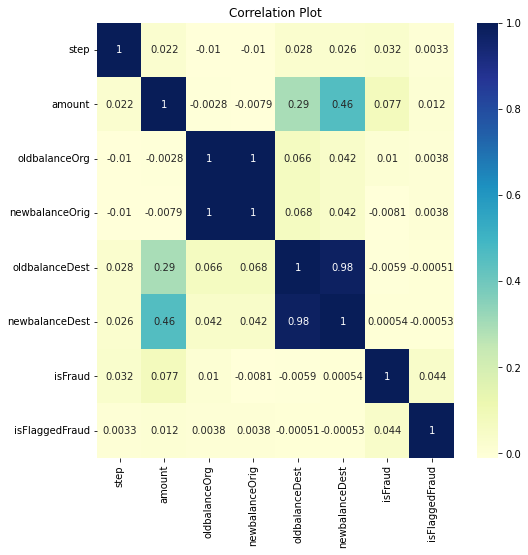

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot = True, fmt='.2g',cmap= 'YlGnBu')
plt.title('Correlation Plot')
plt.show()

 - **Observations:**
  - oldbalanceOrig & newbalanceOrig are highly correlated.
  - oldbalanceDest & newbalanceDest are highly correlated.
  - For rest of all there is no signifiacant correlation.
  - For target variable isFraud, no feature is highly correlated.

#### Feature: type

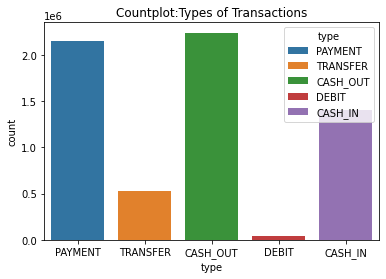

In [ ]:
#Plotting counts of transactions as per type feature
sns.countplot(data=df,x='type',hue='type',dodge=False)
plt.title('Countplot:Types of Transactions')
plt.show()

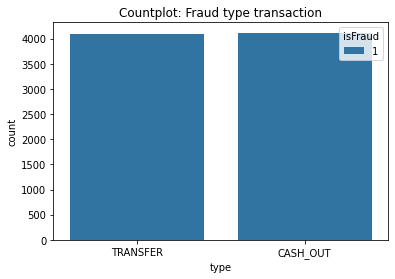

In [ ]:
#identifying which type of transactions are isFraud
df['type'][df['isFraud']==1].value_counts()

#plot
sns.countplot(data=df[df['isFraud']==1],x='type',hue='isFraud',dodge=False)
plt.title('Countplot: Fraud type transaction')
plt.show()

In [ ]:
# Filtering  fraud and valid types of transactions
fraud = df[df["isFraud"] == 1]
valid = df[df["isFraud"] == 0]

In [ ]:
#Checking types of transactions in fraud and valid transactions data

#fraud data
print('types of Transactions in Fraud transactions = ')
print(fraud['type'].value_counts())
print('='*50)

#valid data
print('types of Transactions in valid transactions = ')
print(valid['type'].value_counts())

types of Transactions in Fraud transactions = 
CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64
types of Transactions in valid transactions = 
CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64


- **Observations**
  - There are 4 types of transactions - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
  - Among those only **CASH_OUT & TRANSFER are isFraud==1**.
  

#### Feature: nameDest and nameOrig

- As per dataset description provided the initials of nameOrig and nameDest denotes type of acccount. 
  - C : Customer
  - M : Merchant

In [ ]:
#Identifying account types between transaction happened

print('nameOrig feature:')
print('-'*50)
print('No of transactions where type of acount is C:',
      df['nameOrig'].str.contains('C').sum())

print('No of transactions where type of acount is M:',
      df['nameOrig'].str.contains('M').sum())

print('='*50)

print('nameDest feature:')
print('-'*50)
print('No of transactions where type of acount is C:',
      df['nameDest'].str.contains('C').sum())
print('No of transactions where type of acount is M:',
      df['nameDest'].str.contains('M').sum())

nameOrig feature:
--------------------------------------------------
No of transactions where type of acount is C: 6362620
No of transactions where type of acount is M: 0
nameDest feature:
--------------------------------------------------
No of transactions where type of acount is C: 4211125
No of transactions where type of acount is M: 2151495


- Observation 
  - nameOrig feature doesnt have 'M' type account. All accounts are 'C'

  - nameDest feature contains both 'C' and 'M' type acounts

In [ ]:
# Create a feature "type1" which is a categorical with  "CC" (Customer to Customer), "CM" (Customer to Merchant), 
# "MC" (Merchant to Customer), "MM" (Merchant to Merchant).

df['account_transactions'] = 0
df.loc[df['nameOrig'].str.contains('C') & df['nameDest'].str.contains('M'),'account_transactions'] = 'CM'
df.loc[df['nameOrig'].str.contains('C') & df['nameDest'].str.contains('C'),'account_transactions'] = 'CC'
df.loc[df['nameOrig'].str.contains('M') & df['nameDest'].str.contains('C'),'account_transactions'] = 'MC'
df.loc[df['nameOrig'].str.contains('M') & df['nameDest'].str.contains('M'),'account_transactions'] = 'MM'

Account_transcation counts as per CC CM MC MM = 
 CC    4211125
CM    2151495
Name: account_transactions, dtype: int64
--------------------------------------------------


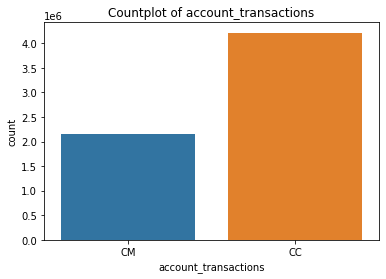

In [ ]:
print('Account_transcation counts as per CC CM MC MM = \n',
      df['account_transactions'].value_counts())

print('-'*50)
sns.countplot(x=df['account_transactions'])
plt.title('Countplot of account_transactions')
plt.show()

- Observations : 
  From above plot we can see there are only CC,CM types of transactions in the whole dataset

In [ ]:
#Account type transaction wrt Valid and Fraud transactions
# Filtering  fraud and valid types of transactions
fraud = df[df["isFraud"] == 1]
valid = df[df["isFraud"] == 0]

Account_transcation counts as per CC CM MC MM = 
 CC    8213
Name: account_transactions, dtype: int64
--------------------------------------------------


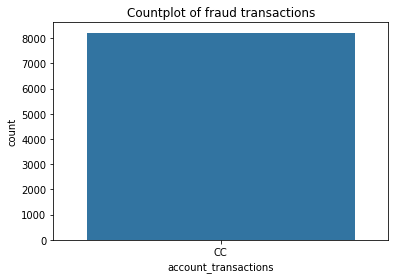

In [ ]:
#Plots
print('Account_transcation counts as per CC CM MC MM = \n',
      fraud['account_transactions'].value_counts())

print('-'*50)
sns.countplot(x=fraud['account_transactions'])
plt.title('Countplot of fraud transactions')

plt.show()

Account_transcation values as per CC CM MC MM = 
 CC    4202912
CM    2151495
Name: account_transactions, dtype: int64
--------------------------------------------------


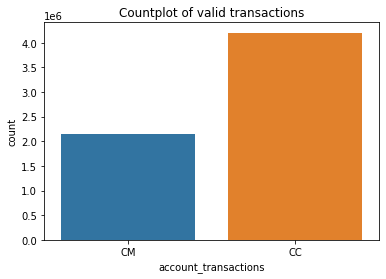

In [ ]:
print('Account_transcation values as per CC CM MC MM = \n',
      valid['account_transactions'].value_counts())

print('-'*50)
sns.countplot(x=valid['account_transactions'])
plt.title('Countplot of valid transactions')

plt.show()

- observations
  - From above 2 graphs we can see **fraud transactions have only CC type** of account transactions. This is point to notices
  
  - From above 2 graphs we can see **valid transactions have CC,CM type of account** transactions.

- As per dataset description given,isFraud transactions are the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- This means fraud transactions are only of CASH_OUT & TRANSFER type.


In [ ]:
#Lets check if the recipient account of a fraudulent transfer was used as a sending account for cashing out 
fraud['nameDest'].isin(fraud['nameOrig']).any()

False

- This tells that for fraud transactions, the account that received funds during a transfer was not used at all for cashing out.

- Hence there is no use of nameOrg and nameDest. Hence we can drop those features. 

#### Feature: Amount

In [ ]:
#cheking statistics of fraud transactions
print('Fraud transactions:')
print('-'*50)

print('Mean is = ',fraud['amount'].mean())
print('Min amount = ',fraud['amount'].min())
print('Max amount = ',fraud['amount'].max())

Fraud transactions:
--------------------------------------------------
Mean is =  1467967.299140387
Min amount =  0.0
Max amount =  10000000.0


In [ ]:
#cheking statistics of valid transactions

print('Valid transactions:')
print('-'*50)
print('Mean is = ',valid['amount'].mean())
print('Min amount = ',valid['amount'].min())
print('Max amount = ',valid['amount'].max())

Valid transactions:
--------------------------------------------------
Mean is =  178197.04172740763
Min amount =  0.01
Max amount =  92445516.64


In [ ]:
#checking percentile wise amount values

for i in range(0,101,10):
  print(f'{i}th percentile is = ',int(np.percentile(fraud['amount'],i)))

0th percentile is =  0
10th percentile is =  37720
20th percentile is =  94035
30th percentile is =  166880
40th percentile is =  276042
50th percentile is =  441423
60th percentile is =  712043
70th percentile is =  1159831
80th percentile is =  2059980
90th percentile is =  4521723
100th percentile is =  10000000


In [ ]:
#checking percentile wise amount values
for i in range(0,101,10):
  print(f'{i}th percentile is = ',int(np.percentile(valid['amount'],i)))

0th percentile is =  0
10th percentile is =  4496
20th percentile is =  9851
30th percentile is =  18056
40th percentile is =  36260
50th percentile is =  74684
60th percentile is =  122331
70th percentile is =  176490
80th percentile is =  246148
90th percentile is =  364373
100th percentile is =  92445516


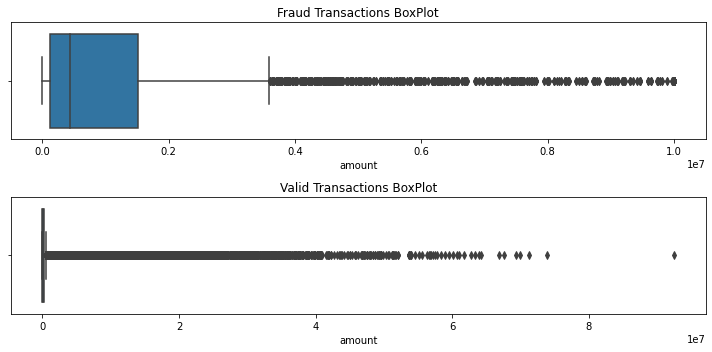

In [ ]:
#boxplot of fraud amount
plt.figure(figsize=(10,5))
plt.subplot(2, 1, 1)
sns.boxplot(data=fraud,x='amount')
plt.title('Fraud Transactions BoxPlot')

plt.subplot(2, 1, 2)
#boxplot of fraud amount
sns.boxplot(data=valid,x='amount')
plt.title('Valid Transactions BoxPlot')

plt.tight_layout()
plt.show()


- **Observations**
  - If we see percentiles data of Valid transations, 90% transaction amounts are below 0.36 million. 
  - And if  we see percentiles data of Valid transations, 90% transaction amounts are below 4.5 million.
  - We can see boxplot comparison of Fraud and valid transaction. Fraud transactions amount is  very large in amount compared to Valid transactions.

#### Feature: isFraudFlagged

In [ ]:
#checking for isFraudFlagged condition
print('No of isFlaggedFraud transactions = ',fraud['isFlaggedFraud'].isin([1]).sum())

No of isFlaggedFraud transactions =  16


In [ ]:
#These are 16 isFlaggedFraud transactions
fraud[fraud['isFlaggedFraud']==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,account_transactions
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1,CC
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1,CC
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1,CC
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1,CC
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1,CC
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1,CC
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1,CC
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1,CC
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1,CC
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1,CC


In [ ]:
# If you see carefully, as per datset description provided it was said that isFlaggedFraud is used only when transfered amount is above 200,000 in a single transaction.

# Identifying observations where the isFraud==1and the transaction type == transfer and the amount> 200,000
print('observations where the isFraud == 1 and the transaction type == TRANSFER and the amount > 200,000:',
      fraud[(fraud['amount'] > 200000) & (fraud['type']=='TRANSFER')]['isFlaggedFraud'].count())

observations where the isFraud == 1 and the transaction type == TRANSFER and the amount > 200,000: 2740


- Observations
  - No of isFlaggedFraud transactions =  16
  - the amount they transfered isn't actually transfered from nameorg to nameDest because their is no chnage in (oldbalanceDest,newbalanceDest).
  - If you see carefully, as per datset description provided it was said that isFlaggedFraud is used only when transfered amount is above 200,000 in a single transaction. But if we see there is 2740 transactions where **isFlaggedfraud is FAILED to mark**.
  - Hence we decide to **DROP this isFlaggedfraud Feature**.

#### Feature: Step

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

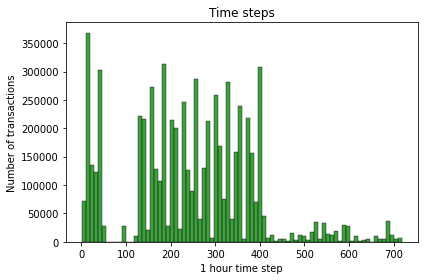

In [ ]:
#checking valid transactions wrt to step
sns.histplot(data=valid,x='step',bins=80,color='g')
plt.xlabel("1 hour time step")
plt.ylabel("Number of transactions")
plt.title("Time steps")

plt.tight_layout()
plt.show()

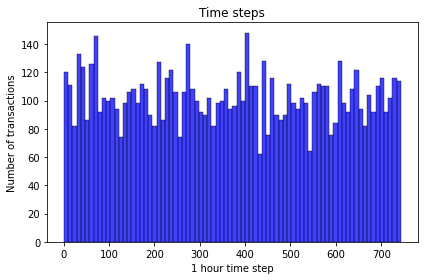

In [ ]:
#checking fraud transactions wrt to step
sns.histplot(data=fraud,x='step',bins=80,color='b')
plt.xlabel("1 hour time step")
plt.ylabel("Number of transactions")
plt.title("Time steps")

plt.tight_layout()
plt.show()

- **Observations**
  - A large proportion of valid transactions occur between around the (10th and 50th) and the (120th and 400th) time-steps.
 - The frequency at which fraudulent transactions occur does not seem to change much over time.

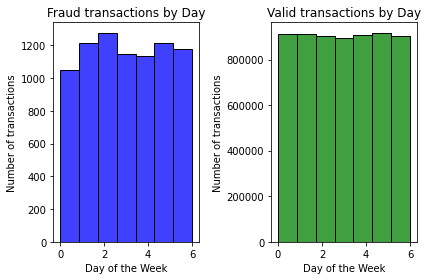

In [ ]:
#checking valid and fraud transaction wrt days of 30 days
plt.subplot(1, 2, 1)
sns.histplot(data=fraud['step']%7,bins=7,color='b')
plt.title('Fraud transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("Number of transactions")

plt.subplot(1,2,2)

sns.histplot(data=valid['step']%7,bins=7,color='g')
plt.title('Valid transactions by Day')
# plt.xlim(0,8)
plt.xlabel('Day of the Week')
plt.ylabel("Number of transactions")

plt.tight_layout()
plt.show()

- Observations
  - Fraud and valid transactions occur daiy.There is no specific pattern observed.

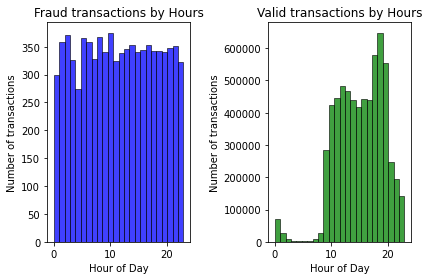

In [ ]:
#checking valid and fraud transaction wrt days of 30 days
plt.subplot(1, 2, 1)
sns.histplot(data=fraud['step']%24,bins=24,color='b')
plt.title('Fraud transactions by Hours')
# plt.xlim(0,25)
plt.xlabel('Hour of Day')
plt.ylabel("Number of transactions")

plt.subplot(1,2,2)

sns.histplot(data=valid['step']%24,bins=24,color='g')
plt.title('Valid transactions by Hours')
# plt.xlim(0,25)
plt.xlabel('Hour of Day')
plt.ylabel("Number of transactions")

plt.tight_layout()
plt.show()

- **Observation**
  - Valid transactions occur only after 10:00 of the day till 22:00.
  - Fraud transactions occur at any time of the day
  - This Hours_of_data can be an important reason to differentiate between fraud and valid transactions. Hence We will include the new feature 'Hour of day' as to denote what hour of day is it.

#### Feature: Balance before and after transaction (errorbalance)

In [ ]:
#if type of transaction is {CASH_OUT,DEBIT,TRANSFER} then newbalanceOrig = oldbalanceOrig - amount
# if type of transaction is {CASH_IN} then newbalanceOrig = oldbalanceOrig + amount

#Make copy of column 'type' and repalcing CASH_IN as 1 and rest all with -1.
df['type_sign'] = df['type']
df['type_sign'] = df['type_sign'].apply(lambda x: 1 if x =='CASH_IN' else -1)

#Multiplying 'type_sign' and 'amount' columns to get actual representation of type of transaction
df['amount_sign'] = df['type_sign'] * df['amount']
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,account_transactions,type_sign,amount_sign
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CM,-1,-9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CM,-1,-1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC,-1,-181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC,-1,-181.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CM,-1,-11668.14


In [ ]:
##Calculating percentage of transactions having error in balance of Origin of transaction
print('Percent of transactions having error in oldbalance and newbalance of Orig = ',
      (df['newbalanceOrig'] + df['amount_sign'] != df['oldbalanceOrg']).sum() / len(df) * 100)

#Calculating percentage of transactions having error in balance of Destination of transaction
print('Percent of transactions having error in oldbalance and newbalance of Orig = ',
      (df['oldbalanceDest'] - df['amount_sign'] != df['newbalanceDest']).sum() / len(df) * 100)

Percent of transactions having error in oldbalance and newbalance of Orig =  99.99974853126542
Percent of transactions having error in oldbalance and newbalance of Orig =  67.01844523168128


In [ ]:
#Drop features
df.drop(['type_sign','amount_sign'],axis=1,inplace=True)

In [ ]:
#Lets check error wrt fraud and valid transaction
# adding features errorBalanceOrg, errorBalanceDest
df["errorBalanceOrg"] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df["errorBalanceDest"] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,account_transactions,errorBalanceOrg,errorBalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CM,0.0,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CM,0.0,1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC,0.0,181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC,0.0,21363.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CM,0.0,11668.14


In [ ]:
#Separating fraud and valid types of transactions
fraud = df[df["isFraud"] == 1]
valid = df[df["isFraud"] == 0]

In [ ]:
#ErrorbalanceOrg statistics
print('ErrorbalanceOrig statistics Statistics')
print('-'*100)

print('Valid transactions Statistics')
print(valid['errorBalanceOrg'].describe())
print('='*80)
print('Fraud transactions Statistics')
print(fraud['errorBalanceOrg'].describe())

ErrorbalanceOrig statistics Statistics
----------------------------------------------------------------------------------------------------
Valid transactions Statistics
count    6.354407e+06
mean     2.013386e+05
std      6.069289e+05
min     -1.000000e-02
25%      3.034305e+03
50%      6.904931e+04
75%      2.499534e+05
max      9.244552e+07
Name: errorBalanceOrg, dtype: float64
Fraud transactions Statistics
count    8.213000e+03
mean     1.069233e+04
std      2.651461e+05
min     -7.450581e-09
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+07
Name: errorBalanceOrg, dtype: float64


- Observation 
  - **Most of the errorbalanceOrg of fraud transactions are -ve and upto 75% transactions are having error value less than 0. Hence this can be signifiacant point to categories valid and fraud transactions**
  - while in case of valid transactions have large errorbalanceorig

In [ ]:
#ErrorbalanceDest statistics
print('ErrorbalanceOrig statistics')
print('-'*100)

print('Valid transactions Statistics')
print(valid['errorBalanceDest'].describe())
print('='*80)

print('Fraud transactions Statistics')
print(fraud['errorBalanceDest'].describe())

ErrorbalanceOrig statistics
----------------------------------------------------------------------------------------------------
Valid transactions Statistics
count    6.354407e+06
mean     5.469223e+04
std      4.360026e+05
min     -7.588573e+07
25%      0.000000e+00
50%      3.500680e+03
75%      2.925981e+04
max      1.319123e+07
Name: errorBalanceDest, dtype: float64
Fraud transactions Statistics
count    8.213000e+03
mean     7.325093e+05
std      1.867748e+06
min     -8.875516e+06
25%      0.000000e+00
50%      2.231460e+03
75%      4.427220e+05
max      1.000000e+07
Name: errorBalanceDest, dtype: float64


- Observation
  - Both fraud and valid transactions have high value of errorbalanceDest.
  

In [ ]:
print("Proportion of fraudulent_transactions with erroralanceDest > 0 =  ", np.round(len(fraud[fraud['errorBalanceDest'] > 0])/len(fraud),2))
print('=='*50)
print("Proportion of valid_transactions with errorBalanceDest > 0 = ", np.round(len(valid[valid['errorBalanceDest'] > 0])/len(valid),2))
print('=='*50)
print("Proportion of fraudulent_transactions with errorBalanceOrg > 0 = ", np.round(len(fraud[fraud['errorBalanceOrg'] > 0])/len(fraud),3))
print('=='*50)
print("Proportion of valid_transactions with errorBalanceOrg > 0 = ", np.round(len(valid[valid['errorBalanceOrg'] > 0])/len(valid),3))

Proportion of fraudulent_transactions with erroralanceDest > 0 =   0.57
Proportion of valid_transactions with errorBalanceDest > 0 =  0.64
Proportion of fraudulent_transactions with errorBalanceOrg > 0 =  0.006
Proportion of valid_transactions with errorBalanceOrg > 0 =  0.804


- observation with proportion 
  - Valid transaction are likely to have more error in balanceOrg
  - Fraud transaction have less proportion in errorbalanceOrg

# **2. Preprocessing**

- **Drop isFlaggered feature** because there are error in marking isFlaggedFrauds.
-  **Drop nameOrig,nameDest** because fraud type transactions are only Customer_Customer type transactions as per EDA.
- We will add 3 new features :
  - errorBalanceOrg :
  - errorBalanceDest :
  - Hour_Of_Day :

- We will consider **only datapoints whos transaction type is CASH_OUT or TRANSFER**,because these are datapoints having fraud transactions

In [ ]:
#Reading data file
df = pd.read_csv(file)

# Filter only datapoints whos transaction type is CASH_OUT or TRANSFER**
df = df[df['type'].isin(['TRANSFER','CASH_OUT'])]
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [ ]:
#Converting Categorical features to OneHotEncoded Features
ohe_type=pd.get_dummies(df['type'],prefix='type')

#Appending OHE features
df  = pd.concat([ohe_type,df],axis=1)
df.head()

,type_CASH_OUT,type_TRANSFER,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,0,1,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,0,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,0,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,0,1,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,0,1,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [ ]:
# adding features errorBalanceOrg, errorBalanceDest
df["errorBalanceOrg"] = df.newbalanceOrig + df.amount - df.oldbalanceOrg
df["errorBalanceDest"] = df.oldbalanceDest + df.amount - df.newbalanceDest
df.head()

,type_CASH_OUT,type_TRANSFER,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrg,errorBalanceDest
2,0,1,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,0.00,181.0
3,1,0,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,0.00,21363.0
15,1,0,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,213808.94,182703.5
19,0,1,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,214605.30,237735.3
24,0,1,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,300850.89,-2401220.0


In [ ]:
# Hour_Of_Day time step feature
df["Hour_Of_Day"]= df.step % 24

df.tail()

,type_CASH_OUT,type_TRANSFER,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrg,errorBalanceDest,Hour_Of_Day
6362615,1,0,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,0.0,0.000000e+00,23
6362616,0,1,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,0.0,6.311409e+06,23
6362617,1,0,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,0.0,1.000000e-02,23
6362618,0,1,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0,0.0,8.500025e+05,23
6362619,1,0,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0,0.0,9.313226e-10,23


In [ ]:
#Droping Features
df = df.drop(['isFlaggedFraud','nameOrig','nameDest','type'],axis=1)
df.head()

,type_CASH_OUT,type_TRANSFER,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,Hour_Of_Day
2,0,1,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,1
3,1,0,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1
15,1,0,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,1
19,0,1,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,1
24,0,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,1


In [ ]:
#print
df.shape

(2770409, 12)

## Splitting Data

In [ ]:
#Splitting the data
X = df.drop(['isFraud'],axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,random_state=42)

In [ ]:
# np.unique(y,return_counts=True)
# np.unique(y_test,return_counts=True)

## Standardizing the data

In [ ]:
# Normalizing data so that all variables follow the same scale (0 to 1)
std = StandardScaler()

# Fit only to the training data
std.fit(X_train)

# Now apply the transformations to the data:
X_train = std.transform(X_train)
X_test = std.transform(X_test)

#### Confusion Matrix Plot function

In [ ]:
def CM_plotter(predictions_train,predictions_test):
  group_names = ['TN','FP','FN','TP']

  #creating arrays
  cm_train = np.array(confusion_matrix(y_train, predictions_train))
  cm_test = np.array(confusion_matrix(y_test, predictions_test))
    

  fig = plt.figure(figsize=(10,4))

  #Train

  group_counts = ['{}'.format(value) for value in cm_train.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cm_train.flatten()/np.sum(cm_train)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  plt.subplot(1,2,1)
  sns.heatmap(cm_train, annot=labels,fmt='',cmap='Blues')
  plt.title('Train_RF')
  plt.xlabel('pred')
  plt.ylabel('true')
  fig.tight_layout()
  # plt.show()

  #Test
  group_counts = ['{}'.format(value) for value in cm_test.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cm_test.flatten()/np.sum(cm_test)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  plt.subplot(1,2,2)
  sns.heatmap(cm_test, annot=labels,fmt='',cmap='Blues')
  plt.title('Test_RF')
  plt.xlabel('pred')
  plt.ylabel('true')
  fig.tight_layout()
  plt.show()

# **3. Models**

## 1. Logistic regression

### GridSearchCV

In [ ]:
#parameters
parameters = {'C' :[0.001,0.01,1,10]}
log_reg = LogisticRegression(class_weight='balanced',penalty='l2')

In [ ]:
#Tunning Log Regression using GridSearchCV
gridcv = GridSearchCV(log_reg,param_grid=parameters,cv=5,scoring='roc_auc',return_train_score=True)

In [ ]:
#Fitting on data || Train Time = 4min
gridcv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 1, 10]}, return_train_score=True,
             scoring='roc_auc')

In [ ]:
#extracting results of GridCV
roc_auc_score_train= gridcv.cv_results_['mean_train_score']
train_auc_std= gridcv.cv_results_['std_train_score']
roc_auc_score_cv = gridcv.cv_results_['mean_test_score']
cv_auc_std= gridcv.cv_results_['std_test_score']

#storing best parameters
best_C=gridcv.best_params_['C']
# best_C=gridcv.best_params_['alpha']
best_score=gridcv.best_score_

In [ ]:
print("BEST parameters C: ",gridcv.best_params_['C']," BEST SCORE: ",gridcv.best_score_)
# print("BEST C: ",gridcv.best_params_['alpha']," BEST SCORE: ",gridcv.best_score_)

BEST parameters C:  10  BEST SCORE:  0.9788725444767865


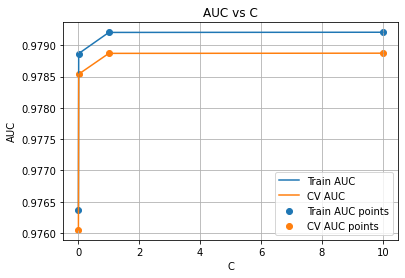

In [ ]:
C = [0.001,0.01,1,10]
plt.plot(C, roc_auc_score_train, label='Train AUC')
plt.plot(C, roc_auc_score_cv, label='CV AUC')
plt.scatter(C, roc_auc_score_train, label='Train AUC points')
plt.scatter(C, roc_auc_score_cv, label='CV AUC points')
plt.legend()
plt.xlabel("C")
plt.ylabel("AUC")
plt.title("AUC vs C")
plt.grid()
plt.show()

### Training LR model on best parameters

In [ ]:
# Train time = 15 sec
log_reg_best = LogisticRegression(C=gridcv.best_params_['C'],class_weight='balanced')
log_reg_best.fit(X_train,y_train)

LogisticRegression(C=10, class_weight='balanced')

In [ ]:
#predicting labels
predictions_train_LR = log_reg_best.predict(X_train)
predictions_test_LR = log_reg_best.predict(X_test)

#predicting probablities
y_tr_pred_proba_LR = log_reg_best.predict_proba(X_train)
y_test_pred_proba_LR = log_reg_best.predict_proba(X_test)

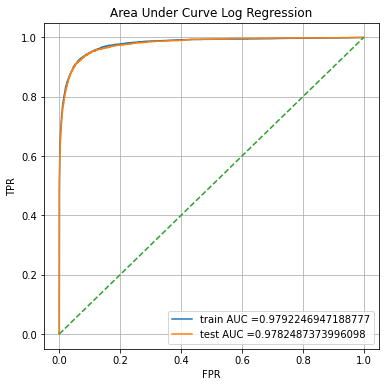

In [ ]:
#extracting fpr,tpr,threshold_prob_value
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_tr_pred_proba_LR[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_proba_LR[:,1])

fig = plt.figure(figsize=(6,6))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(test_fpr, test_fpr,linestyle='--')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Area Under Curve Log Regression")
plt.grid()
plt.show()

#AUC_scores
train_auc_LR = np.round(auc(train_fpr, train_tpr),3)
test_auc_LR = np.round(auc(test_fpr, test_tpr),3)

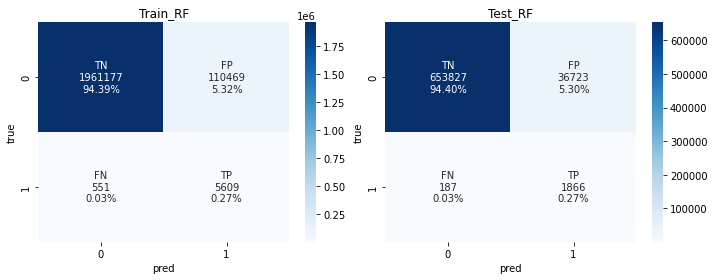

In [ ]:
#Plotting confusion matrix
CM_plotter(predictions_train_LR,predictions_test_LR)

In [ ]:
# Evaluating model

CR_LR = classification_report(y_test,predictions_test_LR)
print('ClassiFication Report:',CR_LR)

ClassiFication Report:               precision    recall  f1-score   support

           0       1.00      0.95      0.97    690550
           1       0.05      0.91      0.09      2053

    accuracy                           0.95    692603
   macro avg       0.52      0.93      0.53    692603
weighted avg       1.00      0.95      0.97    692603



## 2. RandomForest

In [ ]:
# Train model : 5.20 mins
RF = RandomForestClassifier(n_estimators=50,oob_score=True,class_weight='balanced_subsample',random_state=42,bootstrap=True)
fitted_vals = RF.fit(X_train, y_train)
 
# Predict on testing set
predictionsRF = RF.predict(X_test)    

In [ ]:
# Predict on testing set
predictions_train_RF = RF.predict(X_train)  
predictions_test_RF = RF.predict(X_test)  

predict_proba_train_RF = RF.predict_proba(X_train)
predict_proba_test_RF = RF.predict_proba(X_test)

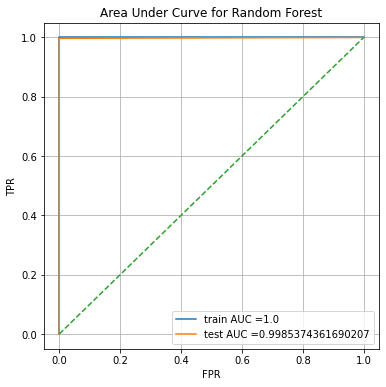

In [ ]:
#extracting fpr,tpr,threshold_prob_value
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, predict_proba_train_RF[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, predict_proba_test_RF[:,1])

fig = plt.figure(figsize=(6,6))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(test_fpr, test_fpr,linestyle='--')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Area Under Curve for Random Forest")
plt.grid()
plt.show()

#AUC_scores
train_auc_RF = np.round(auc(train_fpr, train_tpr),3)
test_auc_RF = np.round(auc(test_fpr, test_tpr),3)

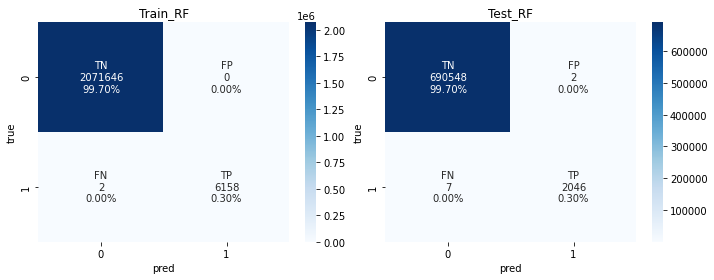

In [ ]:
#Plotting Cinfusion Matrix
CM_plotter(predictions_train_RF,predictions_test_RF)

In [ ]:
# Evaluating model

CR_RF = classification_report(y_test,predictionsRF)
print('ClassiFication Report:',CR_RF)

ClassiFication Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690550
           1       1.00      1.00      1.00      2053

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603



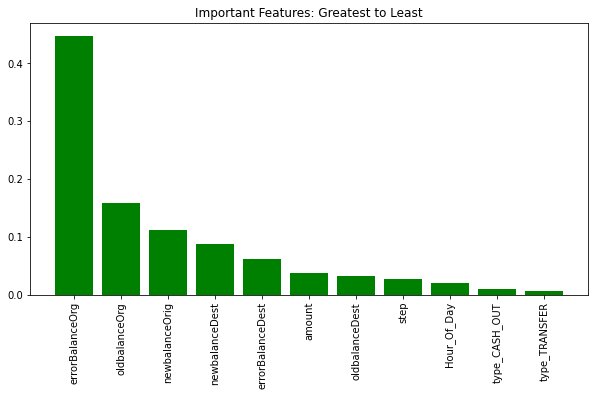

In [ ]:
x = np.arange(len(X.columns))

# getting importances of features
importances = RF.feature_importances_

# getting the indices of the most important feature to least important
sort_ind = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.bar(x, importances[sort_ind],color='g')
plt.xticks(x,tuple(X.columns.values[sort_ind]),rotation=90)
plt.title("Important Features: Greatest to Least")
plt.show()

- observations
  - the feature we created errorbalanceOrg is most important.

# **4. Results**

Logistic Regression
--------------------------------------------------
Test AUC score =  0.978


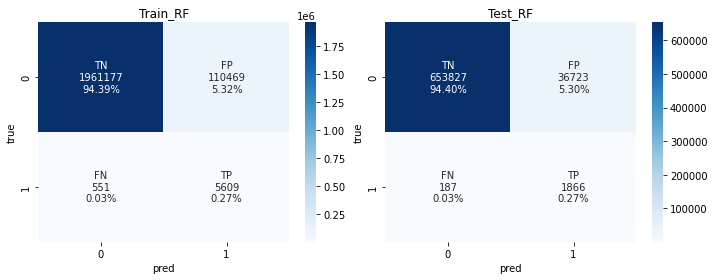

Random Forest
--------------------------------------------------
Test AUC score =  0.999


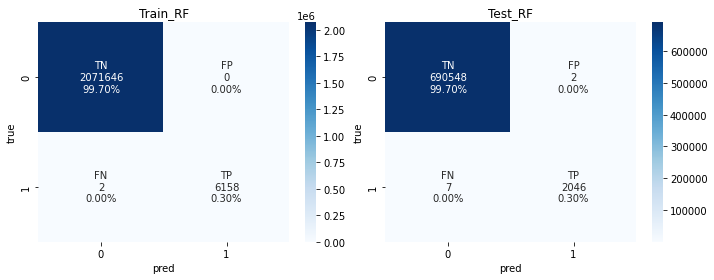


ClassiFication Report LR: 
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    690550
           1       0.05      0.91      0.09      2053

    accuracy                           0.95    692603
   macro avg       0.52      0.93      0.53    692603
weighted avg       1.00      0.95      0.97    692603

--------------------------------------------------------------------------------
ClassiFication Report RF: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690550
           1       1.00      1.00      1.00      2053

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603



In [ ]:
print('Logistic Regression')
print('-'*50)

print('Test AUC score = ',test_auc_LR)
CM_plotter(predictions_train_LR,predictions_test_LR)

print('Random Forest')
print('-'*50)

print('Test AUC score = ',test_auc_RF)
CM_plotter(predictions_train_RF,predictions_test_RF)

print('='*80)
print('='*80)

print()

print('ClassiFication Report LR: ')
print(CR_LR)
print('-'*80)
print('ClassiFication Report RF: ')
print(CR_RF)

- Observations 
  - Random Forest is performing Excellent as compared to Logistic Regression

# **Case Study Questions**

**Q1. Data cleaning including missing values, outliers and multi-collinearity.**

- There was no Missing values or NaN values.
- No need of data cleaning was needed.
The number of fraud transactions is very small as compared to the total number of transactions. The fraud transaction can be considered outliers.

- I worked on outlier detection techniques as below.

  - I implemented the Isolation Forest technique for outlier detection. Thi technique is based on the decision tree and works on isolating the outliers.
  - I also implemented a local outlier factor algorithm for outlier detection. 
  - The density of points in a region is a good differentiator between genuine and fraudulent transactions. 
  - For a fraudulent transaction, the number of data points in the neighborhood is very small. For a genuine transaction, the number of data points in the neighborhood is large.
  - To understand the density, I implemented the DBSCAN technique.
- The results of the oulier detection techniques were not satisfactory. They could not identify the fraudulent transactions correctly.

**Q2. Describe your fraud detection model in elaboration.**

- As Fraud detection is a Binary type of classification task. The dataset provided is Labeled data. So we need ML models which support Supervised and binary types of data.
- After doing EDA of the dataset I found that data is heavily imblanced so I need performance evaluation metrics as :
	  a. Confusion Matrix: To check TP,FP,FN,TN
	  b. Precision : Out of all datapoints predicted as Fraud,how many of them was actually fraud. We want our model which will not miss any fraud transaction.
	  c. Recall: Out of all Fraud transactions how much of them were predicted fraud. Because we want which will not classify fraud transaction as Valid transaction. 
	  d. ROC_AUC: Tells us discriminative power of model between fraud and valid transactions.

- So Model selection criteria becomes:
	  a. Model which does binary classification
	  b. Model which gives Probablity values along with class labels
- Due to this reason I selected Logistic Regression and Random Forest model. 
	  a. Logistic Regression: Supports Binary classification by default and returns probablity values.
	  b. Random Forest: This is ensemble type of model. The performance of these model is Superior  because of combination of multiple base models. Also this model Supports Binary classification and returns probablity values.







**Q3.How did you select variables to be included in the model?**

- The selection of variables was done after performing extensive EDA.
For example, droppping of 'isFlaggedFraud' variable was decided because it was violating the given criteria as per dataset descrition and number of datapoints was only 16.

- For the 'type' of transactions I included only CASH_OUT & TRANSFER transactions. Because fraud was only in those transaction.

- nameOrig and nameDest was dropped because of for fraud transactions, the account that received funds during a transfer was not used at all for cashing out.

- See EDA part for more details.

**Q4. Demonstrate the performance of the model by using best set of tools.**

- As the data was heavily imbalanced, so selecting accuracy as performance metric is not a good idea.Because even dumbe model will give good accuracy.

- So I selected following performance evaluation metrics to evaluate performance of model :
	  a. Confusion Matrix: To check TP,FP,FN,TN
	  b. Precision : Out of all datapoints predicted as Fraud,how many of them was actually fraud. We want our model which will not miss any fraud transaction.
	  c. Recall: Out of all Fraud transactions how much of them were predicted fraud. Because we want model which will not classify fraud transaction as Valid transaction. 
	  d. ROC_AUC: Tells us discriminative power of model between fraud and valid transactions.

**Q5.  What are the key factors that predict fraudulent customer?**

- CASH_OUT and TRANSFER type of transactions are responsible.
- ErrorbalanceOrig and ErrobalanceDest  feature.
- Hours_of_day feature.
- The account that received funds during a transfer was not used at all for cashing out.

**Q6.Do these factors make sense? If yes, How? If not, How not?**

-  Yes, these factors make sense.
Based on domain knowledge and my own study of fraud detection, I believe we can detect fraudulent transactions with high accuracy by deploying my model.
- As per EDA, I separated the fraud and valid transactions. And found that fraud transaction happens only when the transaction type is CASH_OUT and TRANSFER.
- ErrorbalanceOrig and ErrobalanceDest feature:  As per EDA, Most of the errorbalanceOrg of fraud transactions are -ve and up to 75% of transactions are having error value less than 0. Hence this can be a significant point to categories of valid and fraud transactions.While in case of valid transactions have large errorbalanceorig.
- Hours_of_day feature : Valid transactions occur only within specific hours of day.But Fraud transactions occur at any time of the day. This Hours_of_data can be an important reason to differentiate between fraud and valid transactions. 

 

**Q7. What kind of prevention should be adopted while company update its infrastructure?**
- Improve the data collection of 'isFalggedFraud' feature, it's not working as per the criteria provided in the dataset.
- There is a lot of error in tallying the balance of (oldbalanceOrig,newbalanceOrig) and (oldbalanceDest,newbalanceDest)performing after transactions.
-  while updating the company infrastructure, we should collect more features for the transactions. Some examples of additional features that should be collected are as follow.

  - Location of transaction: city, state, the country from IP address - if a user's primary address is Mumbai and if the same users make a large transaction in a North-East Indian state, such transaction is suspicious.
  - Device type of transaction: Android, iOS, Desktop, etc. 
  - Check whether the transaction was done from a user-authorized device or not.
  - For each user, the average amount of transactions (if a user usually makes transactions of small amounts, and suddenly if a new transaction is of a large amount, it could be fraudulent.)
  - For each merchant, the average amount of transaction (if a merchant usually receives transactions of small amounts, and suddenly if a new transaction is of a large amount, it could be fraudulent.)
  - IP Address 
  - User's last known location
  
- Amount of each Fraud transaction is higher compared to a valid transaction. So tracking transactions contain a higher amount with more attention.


**Q8.Assuming these actions have been implemented, how would you determine if they work?**

- We will deploy the fraud detection model. After the deployment, we will continuously monitor the performance of the fraud detection model. 
- We will also periodically re-train the model by adding recent transaction data sets.
- We will also analyze data drift - the change in the type of data as compared to the original trained data. We will analyze the changes in the distribution of the data and make improvements to model parameters accordingly.